# Zigzagを求めてみる

とりあえずソフトバンク株をサンプルにZigzagを計算してみる。
参考にしたのは
[ここ](http://exceltechnical.web.fc2.com/zigzag.html)

## データの整形
カラム名がTradingViewに合わせてあるので、mplfinance用にカラム名を修正。大文字小文字が違ってもNG。
でも、順番はなんでも可。

In [4]:
import sqlite3 as sql
import pandas as pd

code = 9434 #ソフトバンク
con = sql.connect('/workspaces/stock/src/db.sqlite')
try:
    cur = con.cursor()
    df = pd.read_sql_query(f'SELECT date as Date, open as Open, high as High, low as Low, close as Close, volume as Volume FROM History WHERE code = {code}', con)
finally:
    con.close() 
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
print(df)
df.to_csv(f'{code}.csv')

              Open    High     Low   Close    Volume
Date                                                
2023-01-04  1495.5  1499.5  1489.0  1499.0   6331900
2023-01-05  1496.5  1499.5  1488.0  1492.5   5610700
2023-01-06  1494.0  1494.0  1485.5  1490.0   4760400
2023-01-10  1486.0  1488.0  1465.5  1465.5  11604400
2023-01-11  1470.5  1476.0  1462.5  1463.0   8948700
...            ...     ...     ...     ...       ...
2024-03-25  2044.0  2044.0  2026.5  2027.5   7061100
2024-03-26  2034.0  2039.5  2022.5  2023.0   8053800
2024-03-27  2030.0  2041.5  2025.0  2027.0  12155500
2024-03-28  1982.0  1983.5  1938.0  1941.0  16089400
2024-03-29  1946.5  1956.5  1943.0  1950.0   2813500

[304 rows x 5 columns]


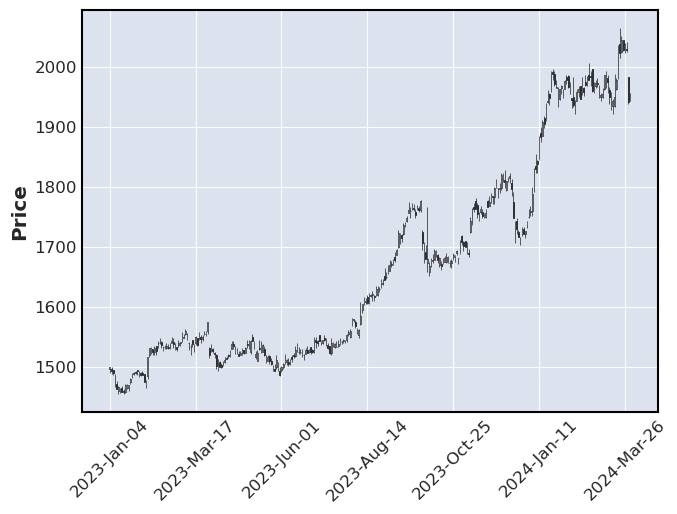

In [11]:
import mplfinance as mpf
mpf.plot(df, type='candle')
mpf.show()

## zigzag計算

本丸のzigzag計算。

Switch列には次の転換日が入っている。(zigzagには不要だが、利益率とか考えるうえで期間は必要かなと)

In [59]:
cp: float = 0.02
prev_trend = 1
prev_provisional = df.Close.iloc[0]

trend = []
provisional = []

for c in df.Close:
    change = (c - prev_provisional) / prev_provisional
    cur_trend = 1 if change > cp \
        else -1 if change < -cp \
        else prev_trend
    cur_provisional = abs(max(cur_trend * c, cur_trend * prev_provisional))
    trend.append(cur_trend)
    provisional.append(cur_provisional)
    prev_trend = cur_trend
    prev_provisional = cur_provisional

df['Trend'] = trend
df['Provisional'] = provisional

fixed = []
switch = []
zigzag = []
cur_fixed = 0
prev_fixed = provisional[-1]
prev_switch = df.index[-1]
for r in df.iloc[::-1].itertuples():
    cur_fixed = abs(max(r.Trend * r.Provisional, r.Trend * prev_fixed))
    fixed.append(cur_fixed)
    prev_fixed = cur_fixed
    switch.append(prev_switch)
    if r.Close == cur_fixed:
        prev_switch = r.Index
        zigzag.append(cur_fixed)
    else:
        zigzag.append(None)

fixed.reverse()
switch.reverse()
zigzag.reverse()
df['Fixed'] = fixed
df['Zigzag'] = zigzag
df['Switch'] = switch

# zigzag = df.query('Close == Fixed')
print(df.loc[:, ['Close', 'Trend', 'Provisional', 'Fixed', 'Zigzag', 'Switch']])
df.to_csv('zigzag.csv')



             Close  Trend  Provisional   Fixed  Zigzag     Switch
Date                                                             
2023-01-04  1499.0      1       1499.0  1499.0  1499.0 2023-01-16
2023-01-05  1492.5      1       1499.0  1499.0     NaN 2023-01-16
2023-01-06  1490.0      1       1499.0  1499.0     NaN 2023-01-16
2023-01-10  1465.5     -1       1465.5  1458.0     NaN 2023-01-16
2023-01-11  1463.0     -1       1463.0  1458.0     NaN 2023-01-16
...            ...    ...          ...     ...     ...        ...
2024-03-25  2027.5      1       2045.0  2045.0     NaN 2024-03-28
2024-03-26  2023.0      1       2045.0  2045.0     NaN 2024-03-28
2024-03-27  2027.0      1       2045.0  2045.0     NaN 2024-03-28
2024-03-28  1941.0     -1       1941.0  1941.0  1941.0 2024-03-29
2024-03-29  1950.0     -1       1941.0  1941.0     NaN 2024-03-29

[304 rows x 6 columns]


で、可視化。

mplfinanceの仕様上、サンプリング数を合わせなきゃいけないらしいので、飛び飛びになっているZigzag列を線形補間してやる。

Date
2023-01-04    1499.000000
2023-01-05    1493.142857
2023-01-06    1487.285714
2023-01-10    1481.428571
2023-01-11    1475.571429
                 ...     
2024-03-25    2019.000000
2024-03-26    1993.000000
2024-03-27    1967.000000
2024-03-28    1941.000000
2024-03-29    1941.000000
Name: Zigzag, Length: 304, dtype: float64


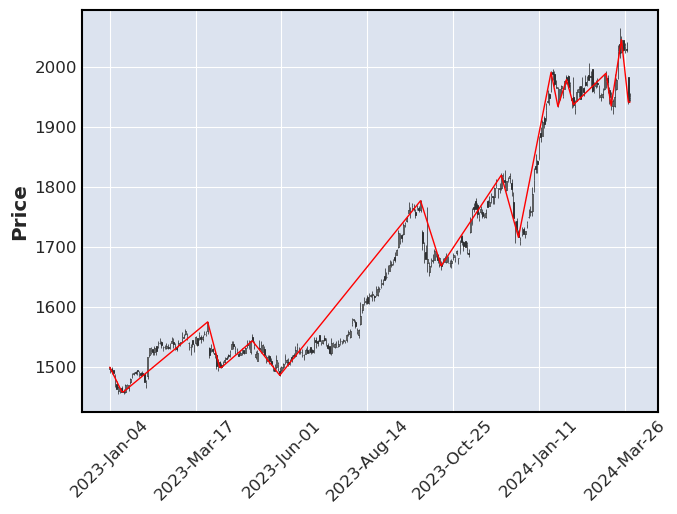

In [61]:
df['Zigzag'].interpolate(inplace=True)
series = [
    mpf.make_addplot(df['Zigzag'], color='#FF0000', width=1, linestyle='solid')
]
print(df['Zigzag'])
mpf.plot(df, type='candle', addplot=series)

